 ### please re-start kernel if these packages are installed for the first time

In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

### This template is for
- objFuncs: v1.0.4  
- pyBO: v1.0.2

In [3]:
import objFuncs
from objFuncs import maximize_FC, construct_machineIO
from objFuncs.preset import get_preset, get_tolerance, get_limits
from pyBO import pyBO

objFuncs version: 1.0.4. updated on 2024-03-26
pyBO version: 1.0.2. updated on 2024-03-26


In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from phantasy import caget,fetch_data
import pandas as pd

# user inputs
### check and adjust decision (control knobs) and objectives later

In [5]:
is_close_to_opt = True      # True for local optimization. 
sourceFC = 40               # uA
timespan_for_average = 1    # sec  
additional_wait_after_powersupply_ramp  = 0.25 # sec

In [6]:
if is_close_to_opt:
    n_init_budget       = 4   # recommended: number of decision parameters 
    n_global_opt_budget = 0
    n_local_opt_budget  = 20
    n_finetune_budget   = 3   # recommended: less than number of decision parameters 
else:
    n_init_budget       = 20          
    n_global_opt_budget = 20
    n_local_opt_budget  = 20
    n_finetune_budget   = 3    # recommended: less than number of decision parameters 

budget = n_init_budget +n_global_opt_budget +n_local_opt_budget +n_finetune_budget
print(f"budget: {budget}")

budget: 27


# check machineIO, source and beam  

In [7]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = timespan_for_average
objFuncs._global_machineIO._ensure_set_timewait_after_ramp = additional_wait_after_powersupply_ramp

In [8]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS2 48Ca10 A/Q= 4.8


In [9]:
now0 = datetime.datetime.now()
fname = now0.strftime('%Y%m%d_%H%M')+'['+ion+'][pyBO][U-LEBT]FC814'
fname

'20240327_1524[48Ca10][pyBO][U-LEBT]FC814'

# preprare decision ( control knob)

In [10]:
# preset = get_preset('[U-LEBT]FC814')
# preset

In [11]:
decision_CSETs = [
                  'FE_LEBT:PSC2_D0773:I_CSET',
                  'FE_LEBT:PSC1_D0773:I_CSET',
                  'FE_LEBT:PSC2_D0790:I_CSET',
                  'FE_LEBT:PSC1_D0790:I_CSET',
#                   'FE_LEBT:PSOL_D0787:I_CSET',
                  ]
ave, _ = fetch_data(decision_CSETs,0.01)

decision_tols = []
decision_min = []
decision_max = []
for v, PV in zip(ave,decision_CSETs):
    if 'PSC' in PV:
#         decision_min.append(v-0.7*AQ)
#         decision_max.append(v+0.7*AQ)
        decision_min.append( -0.8*AQ)
        decision_max.append( +0.8*AQ)
        decision_tols.append(0.2)
    elif 'PSOL' in PV:
        decision_min.append(0.9*v)
        decision_max.append(1.1*v)
        decision_tols.append(1.0)
    else:
        raise ValueError(f'decision bounds for {PV} cannot be determined')
        
##== Manually set decision bounds and tolerance
# decision_min = [ -5, -5, -5, -5]
# decision_max = [  5,  5,  5,  5]
# decision_tol = [0.2,0.2,0.2,0.2]

assert len(decision_CSETs) == len(decision_min) == len(decision_max) == len(decision_tols)
decision_Lo_limit, decision_Hi_limit = get_limits(decision_CSETs)
decision_min = np.clip(decision_min, a_min = decition_Lo_limit, a_max = None)
decision_max = np.clip(decision_max, a_min = None, a_max = decition_Hi_limit)
assert np.all(decision_max > decision_min)

pd.DataFrame(np.array([ave,decision_min,decision_max,decision_tols,decision_Lo_limit,decision_Hi_limit]).T,
             index=decision_CSETs, 
             columns=['current value','decision min','decision max','tol','LoLim','HiLim'])

,current value,decision min,decision max,tol,op_LoLim,op_HiLim
FE_LEBT:PSC2_D0773:I_CSET,-1.070,-3.84,3.84,0.2,-5.5,5.5
FE_LEBT:PSC1_D0773:I_CSET,0.404,-3.84,3.84,0.2,-5.5,5.5
FE_LEBT:PSC2_D0790:I_CSET,-0.840,-3.84,3.84,0.2,-5.5,5.5
FE_LEBT:PSC1_D0790:I_CSET,-1.121,-3.84,3.84,0.2,-5.5,5.5


# preprare objective function

In [12]:
obj = maximize_FC.maximize_FC814(
    decision_CSETs=decision_CSETs,
    decision_min = decision_min,
    decision_max = decision_max,
    decision_tols = decision_tols,
    objective_goal   = {'FE_LEBT:FC_D0814:PKAVG_RD': {'more than': sourceFC}},
    objective_weight = {'FE_LEBT:FC_D0814:PKAVG_RD': 1},
    objective_norm   = {'FE_LEBT:FC_D0814:PKAVG_RD': 0.2*sourceFC},
)

======== class info ========
init_time: 2024-03-27 15:24:57.925181
class_hierarchy: [
    maximize_FC814, objFuncGoals, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f460387fa10>
decision_CSETs: [
    FE_LEBT:PSC2_D0773:I_CSET, FE_LEBT:PSC1_D0773:I_CSET, FE_LEBT:PSC2_D0790:I_CSET
    FE_LEBT:PSC1_D0790:I_CSET]
decision_min: [-3.84 -3.84 -3.84 -3.84]
decision_max: [3.84 3.84 3.84 3.84]
decision_bounds: [[-3.84  3.84]
 [-3.84  3.84]
 [-3.84  3.84]
 [-3.84  3.84]]
decision_RDs: [
    FE_LEBT:PSC2_D0773:I_RD, FE_LEBT:PSC1_D0773:I_RD, FE_LEBT:PSC2_D0790:I_RD
    FE_LEBT:PSC1_D0790:I_RD]
decision_tols: [0.2 0.2 0.2 0.2]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: FC814
logging_fname: None
x0: [-1.07   0.404 -0.84  -1.121]
plot_time_val: <class 'objFuncs.util.plot_time_val'>
plot_obj_history: <class 'objFuncs.util.plot_obj_history'>
objective_weight: {'FE_LEBT:FC_D0814:PKAVG_RD': 1.0}
objective_goal: {'FE_LEBT

# run Optim

In [13]:
ctrBO = pyBO.bo_controller(obj,local_optimization = is_close_to_opt)

init will random sample within the following bounds:


,min,max
FE_LEBT:PSC2_D0773:I_CSET,-1.454,-0.686
FE_LEBT:PSC1_D0773:I_CSET,0.020,0.788
FE_LEBT:PSC2_D0790:I_CSET,-1.224,-0.456
FE_LEBT:PSC1_D0790:I_CSET,-1.505,-0.737


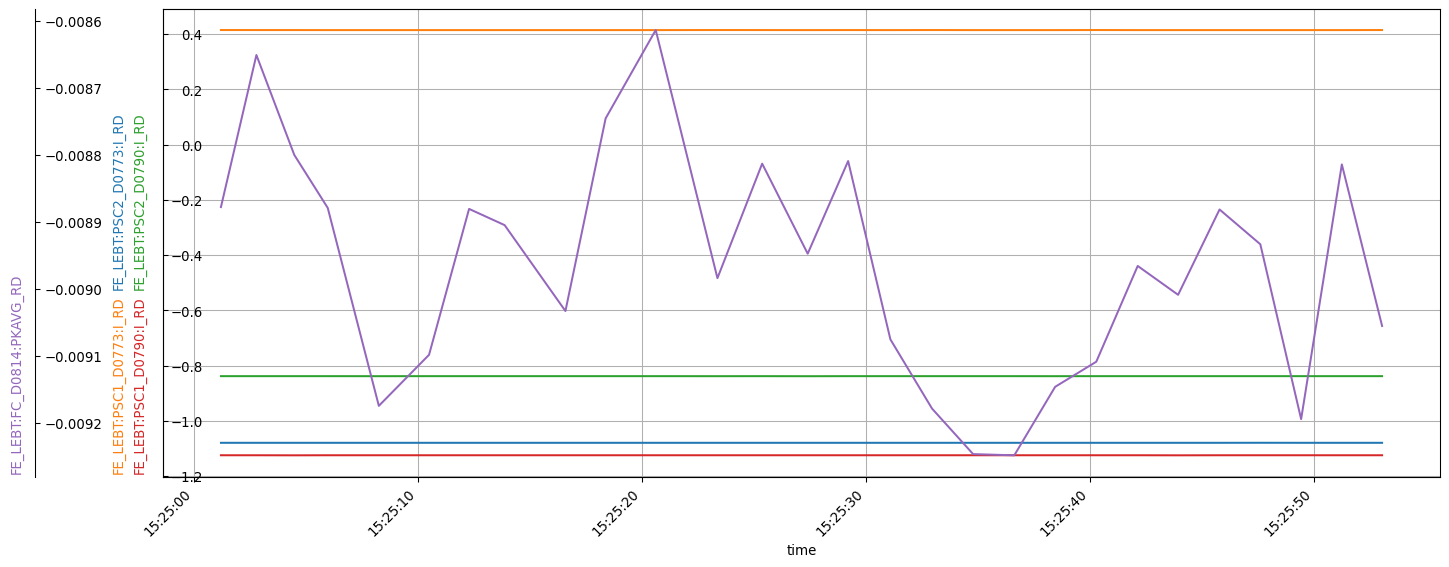

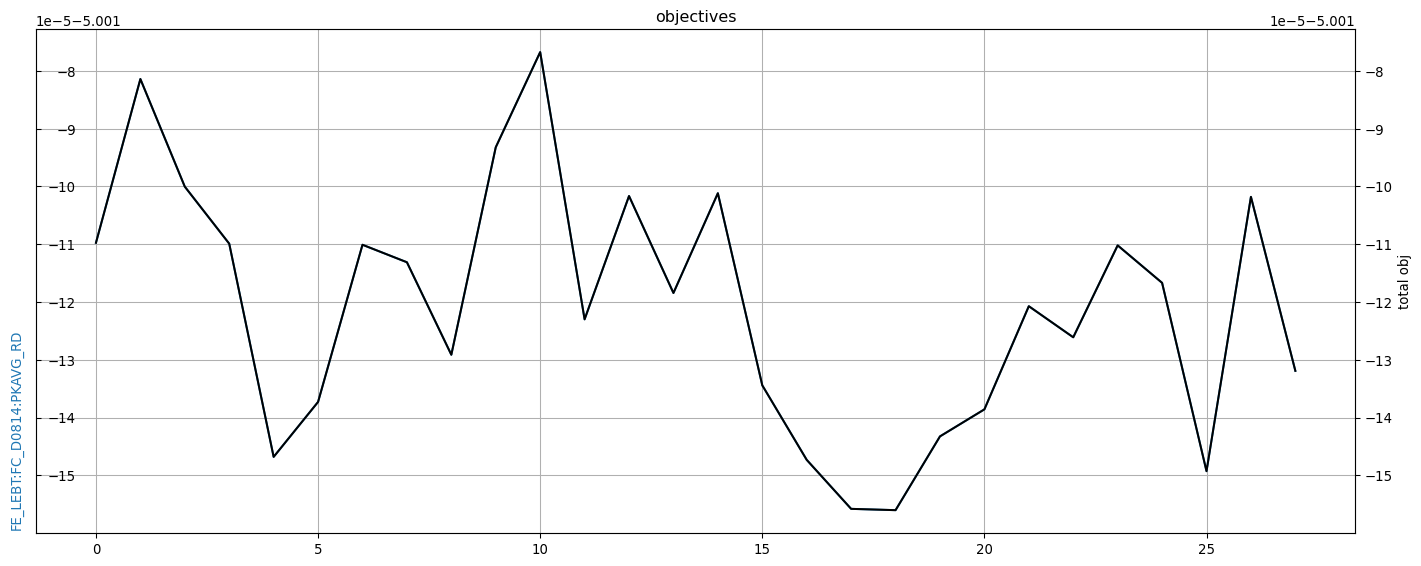

In [14]:
ctrBO.init(n_init_budget)
ctrBO.optimize_global(n_global_opt_budget, beta_scheduler='auto')
ctrBO.optimize_local (n_local_opt_budget , beta_scheduler='auto')
ctrBO.fine_tune(n_finetune_budget)
ctrBO.finalize()
for f in ctrBO.plot_callbacks:
    f.close()

### additional optimization

In [15]:
##== uncomment one (ore more) of the followings to optimize further
# ctrBO.optimize_global(niter=10, beta_scheduler='auto')
# ctrBO.optimize_local (niter=2, beta_scheduler='auto')

##== uncomment the followings too if any of above is uncommented
# ctrBO.fine_tune(niter=1)
# ctrBO.finalize()
# for f in ctrBO.plot_callbacks:
#     f.close()

### plot accumulated best objectives

<AxesSubplot: xlabel='evaluation budget', ylabel='best objective'>

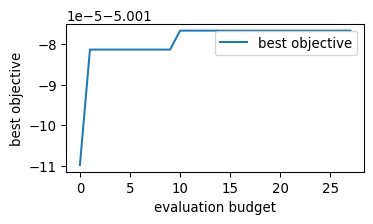

In [16]:
fig,ax = plt.subplots(figsize=(4,2),dpi=96)
ctrBO.bo.plot_obj_history(ax=ax, plot_best_only=True)

### set to best solution 

In [17]:
x_best,y_best_old = ctrBO.bo.best_sofar()
y_best_new = obj(x_best)
print(f'x_best: {x_best}')
print(f'y_best_old: {y_best_old[0]}')
print(f'y_best_new: {y_best_new}')   # check if best solution objective value is consistent

x_best: [-0.8841192   0.17917366 -0.65605157 -1.0798671 ]
y_best_old: -5.001076759681336
y_best_new: -5.00112578109933


In [18]:
obj.save(fname=os.path.join('/files/shared/ap/jupyter-notebook/data/log/',fname))

machineIO is in test mode. skip saving data


# Visualize Surrogate model

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



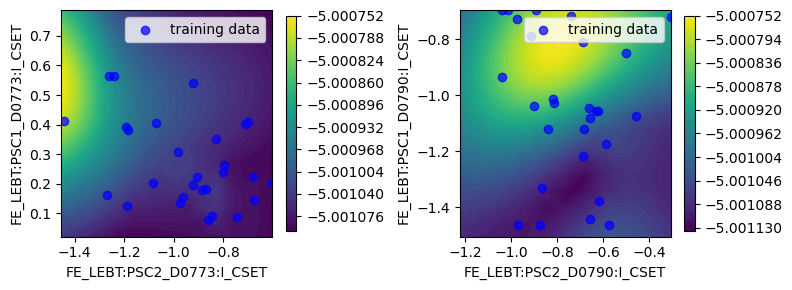

In [19]:
# plot surrogate mean model of the last epoch. Can take long time for decision dim >= 4
bo = ctrBO.bo
from math import ceil
nplot = int(0.5*len(obj.decision_CSETs))
nrow = ceil(0.5*nplot)
fig,ax = plt.subplots(nrow,2,figsize=(8,3*nrow))
for i in range(nrow):
    for j in range(2):
        n = 2*i+j
        if nrow>1:
            ax_ = ax[i,j]
        else:
            ax_ = ax[j]
        if n >= nplot:
            ax_.set_visible(False)
            break
        bo.plot_model_2D_projection(project_maximum=True,
                                    dim_xaxis = 2*n,
                                    dim_yaxis = 2*n+1,
                                    grid_ponits_each_dim = 16,
                                    fig=fig,ax=ax_);
        ax_.set_xlabel(obj.decision_CSETs[2*n  ])
        ax_.set_ylabel(obj.decision_CSETs[2*n+1])
        ax_.legend()
fig.tight_layout()